# Customer Personality Analysis Using Clustering
<br>
We all know how important customer service is while running any kind of business. It is highly important that any company customize their services the fit the needs and pay scale of customers. Here, analytics is a very important thing.
<br>
Customer Personality Analysis helps us in finding the potential customers by analysing the behaviour of them is useful to understand the targeted customers.

### Importing Libraries

In [1]:
# all necessary libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
## All clustering algorithms to import
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as shc
from sklearn.metrics import silhouette_score
from sklearn.cluster import MeanShift,AffinityPropagation
from sklearn.preprocessing import LabelEncoder

In [3]:
#Importing the dataset
data = pd.read_csv("../marketing_campaign.csv",sep='\t')
df = data
df.columns, df.shape

(Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
        'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
        'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
        'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
        'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
        'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
        'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
       dtype='object'),
 (2240, 29))

## Data Cleaning

In [4]:
#checking the data for empty values
df.isna().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [5]:
#removing the columns with no data
df.dropna(inplace=True)
df.shape

(2216, 29)

We can see that we have only lost a few values and not much

## Feature Engineering

We will not use all the columns for our analysis. We will choose only those that are relevant.

We can remove a few redundant columsn like Kids and Teens into a single column. We can do other modifications like that which are defined as follows

* The Year_Birth Can be used to calculate the Age of the Person.<br>
     <i> Age = 2022 - Year_birth </i>
* Both Kidhome and Teenhome can be used to calculate total amount of kids in a household <br>
    <i> Offsprings = Kidhome+Teenhome </i>
* Dt_Customer can be used to calculte how many years the customer has been with the company <br>
     <i> Time = 2022 - Dt_Customer(year) </i>
* All purchases done by customer <br>
     <i> Purchases =  NumCatalogPurchases + NumStorePurchases + NumWebPurchases </i>
* Total Amount of cash spent on purchasing stuff! <br>
     <i> Amount Spent = df['MntWines']+df['MntFruits']+df['MntMeatProducts']+df['MntFishProducts']+df['MntSweetProducts']+df['MntSweetProducts'] </i>

In [6]:
df['Age'] = 2022 - df['Year_Birth']
df['Offsprings'] = df['Kidhome']+df['Teenhome']
df['Years'] = [ 2022 - int(x.split('-')[2]) for x in df['Dt_Customer']]
df['Purchases'] = df['NumWebPurchases']+ df['NumCatalogPurchases'] + df['NumStorePurchases']
df['Money Spent'] =df['MntWines']+df['MntFruits']+df['MntMeatProducts']+df['MntFishProducts']+df['MntSweetProducts']+df['MntGoldProds']

In [7]:
df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'Age', 'Offsprings', 'Years', 'Purchases', 'Money Spent'],
      dtype='object')

In [8]:
# Non-essential columns
drop_col = ['ID','Recency','NumDealsPurchases','AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2','Complain', 'Z_CostContact', 'Z_Revenue', 'Response']
drop_col2 = ['Year_Birth','Kidhome','Teenhome','Dt_Customer']
drop_col3 = ['NumCatalogPurchases','NumStorePurchases','MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']

In [9]:
# Finally dropping the other columns
df.drop(drop_col+drop_col3+drop_col2, axis=1,inplace=True)

### Handling Categorical Values

In [10]:
# Displaying the number of unique values in Marital Status Column
df.Marital_Status.value_counts()

Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64

Here we can see that,there are 8 unique values for Marital_Status...Lets Make it 2 catagories to make the analysis simple.

In [11]:
df["Marital_Status"].replace(["Together","Married"], "Relationship", inplace=True)
df["Marital_Status"].replace(["Divorced","Widow","Alone","Absurd","YOLO"], "Single", inplace=True)

#### There is still 2 categorical labels, 'Marital_Status' and 'Education'. We will handle them using Label Encoder

In [12]:
#Creating a labelEncoder instance
le = LabelEncoder()

# Education
#Creating the label classes for Education
le.fit(df['Education'])
#Storing that in a dictionary for future uses
Education_labels ={i: l for i,l in zip(le.transform(le.classes_),le.classes_)}
# Storing back in dataframe
df['Education']=le.transform(df['Education'])


# Marriage Status
le.fit(df['Marital_Status'])
#Same as above, Storing it in a dictionary for future uses
Marriage_labels = {i: l for i,l in zip(le.transform(le.classes_), le.classes_)}
# Returning Back to dataframe
df['Marital_Status']=le.transform(df['Marital_Status'])

In [13]:
# A dictionary we can use in the future
cat_var = {'Marital_Status':Marriage_labels, 'Education': Education_labels}
cat_var

{'Marital_Status': {0: 'Relationship', 1: 'Single'},
 'Education': {0: '2n Cycle',
  1: 'Basic',
  2: 'Graduation',
  3: 'Master',
  4: 'PhD'}}

In [14]:
# Just defining which are the categorical columns and which are the numerical columns for deriving inference
object_cols = ["Education", "Marital_Status"]
num_cols = data.columns[2:-1]
object_cols, num_cols

(['Education', 'Marital_Status'],
 Index(['Income', 'NumWebPurchases', 'NumWebVisitsMonth', 'Age', 'Offsprings',
        'Years', 'Purchases'],
       dtype='object'))

## Exploratory Data Analysis

In [15]:
df.describe()

,Education,Marital_Status,Income,NumWebPurchases,NumWebVisitsMonth,Age,Offsprings,Years,Purchases,Money Spent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,2.393953,0.354693,52247.251354,4.085289,5.319043,53.179603,0.947202,8.971570,12.557310,607.075361
std,1.124141,0.478528,25173.076661,2.740951,2.425359,11.985554,0.749062,0.685618,7.204611,602.900476
min,0.000000,0.000000,1730.000000,0.000000,0.000000,26.000000,0.000000,8.000000,0.000000,5.000000
25%,2.000000,0.000000,35303.000000,2.000000,3.000000,45.000000,0.000000,9.000000,6.000000,69.000000
50%,2.000000,0.000000,51381.500000,4.000000,6.000000,52.000000,1.000000,9.000000,12.000000,396.500000
75%,3.000000,1.000000,68522.000000,6.000000,7.000000,63.000000,1.000000,9.000000,18.000000,1048.000000
max,4.000000,1.000000,666666.000000,27.000000,20.000000,129.000000,3.000000,10.000000,32.000000,2525.000000


There are some anamolies that we can see.
* We can see that the max age is 129 which is not truly an outlier dataset. Unless we remove it, it will skew our datasets
* We can also see that the maxmium values is 666666.00 which is 10 times greater than the 75th Percentile, which means this is bad for the data, hence we need to limit to the people whose income is less than 6 Million.

All other data seems to be in order

<function matplotlib.pyplot.show(close=None, block=None)>

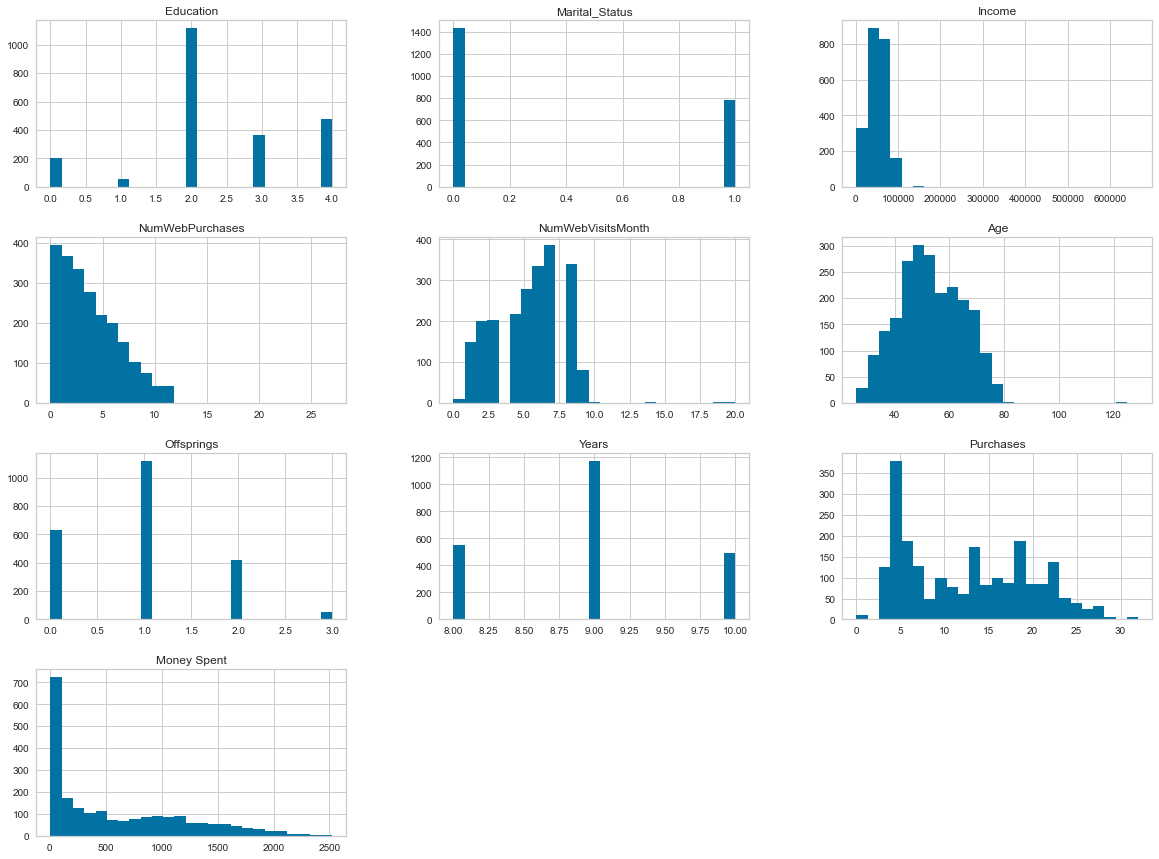

In [16]:
#plotting historgrm to find out more outliers
df.hist(bins = 25, figsize = (20,15))
plt.show

### From the plot we can see that the outliers may be present in fields
1. Income
2. NumWebVisitsMonth
3. Age
4. Purchases
5. Money spent 

we can use box plot to find the outliers more precisely.

<AxesSubplot:>

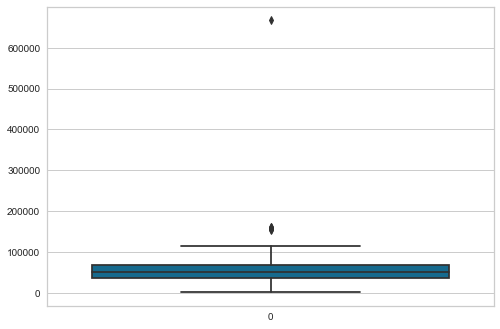

In [17]:
sns.boxplot(data=df.Income)

<AxesSubplot:>

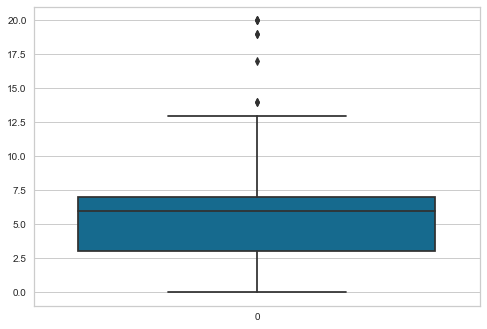

In [18]:
sns.boxplot(data=df['NumWebVisitsMonth'])

<AxesSubplot:>

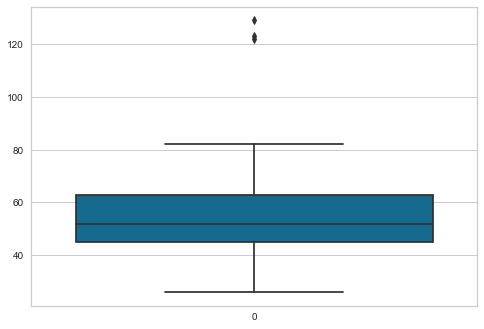

In [19]:
sns.boxplot(data=df.Age)

<AxesSubplot:>

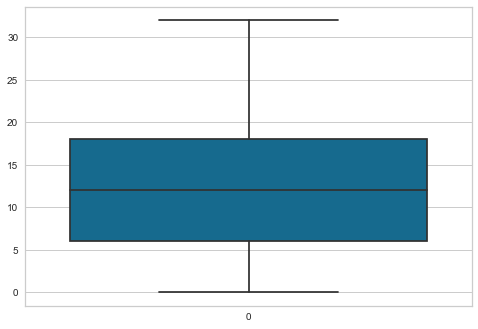

In [20]:
sns.boxplot(data=df['Purchases'])

<AxesSubplot:>

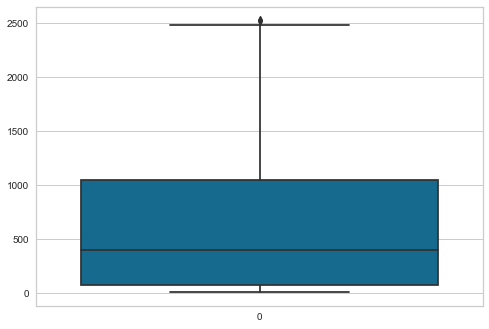

In [21]:
sns.boxplot(data=df['Money Spent'])

### For the above analysis the outliers and their range:
1. Income >150000
2. Money Spent >2500
3. Purchases >30
4. NumWebVisitMonth> 13
5. Age > 80

We need to remove these Outliers

In [22]:
#value before removing outliers
df.count() 

Education            2216
Marital_Status       2216
Income               2216
NumWebPurchases      2216
NumWebVisitsMonth    2216
Age                  2216
Offsprings           2216
Years                2216
Purchases            2216
Money Spent          2216
dtype: int64

In [23]:
#Removing all the outliers according to the above mentioned conditions
df=df[(df['Income']<150000)]
df=df[(df['Money Spent']<2500)]
df=df[(df['Purchases']<30)]
df=df[(df['NumWebVisitsMonth']<13)]
df=df[(df['Age']<80)]

In [24]:
#Value after removing outliers
df.count()

Education            2184
Marital_Status       2184
Income               2184
NumWebPurchases      2184
NumWebVisitsMonth    2184
Age                  2184
Offsprings           2184
Years                2184
Purchases            2184
Money Spent          2184
dtype: int64

We can see that only 32 rows were removed and hence this doesnt affect our analysis.

### Plotting scatterplot to check if all the outliers are removed

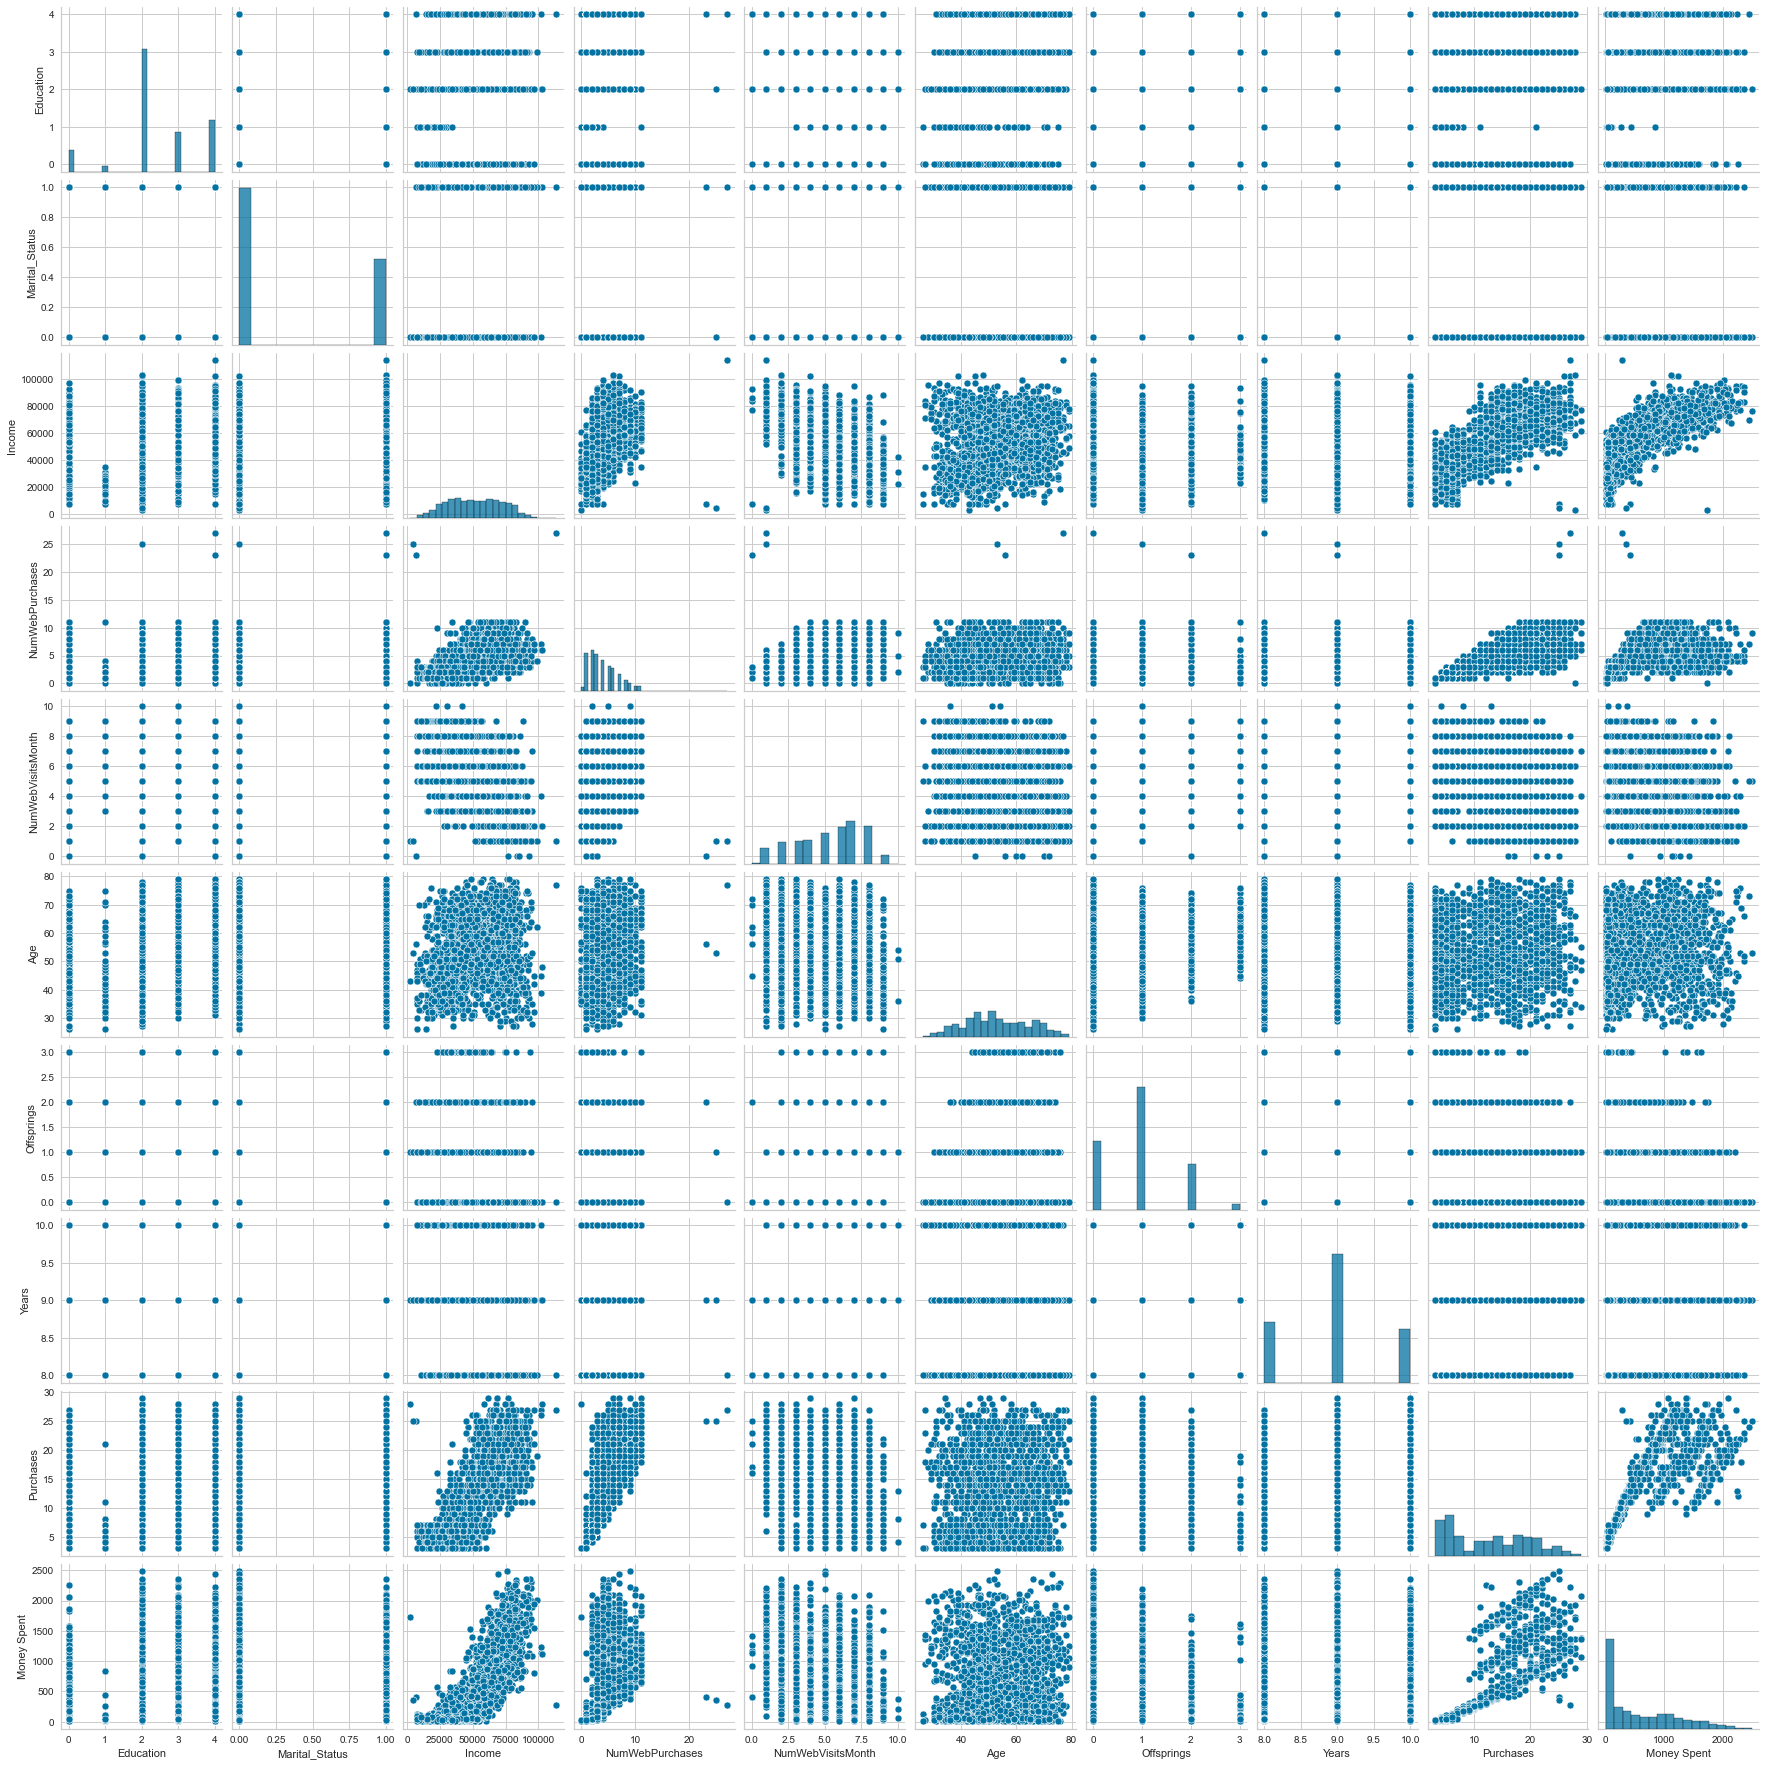

In [25]:
sns.pairplot(df)
plt.show()

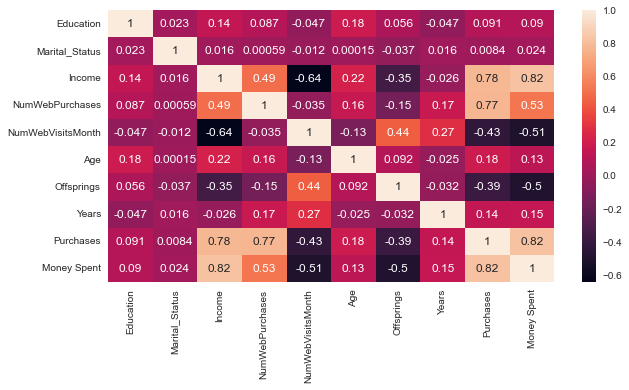

In [26]:
plt.figure(figsize = (10,5))
sns.heatmap(df.corr(),annot= True)
plt.show()

The conclusions we can draw from this plot:
1. Income is closely related with Purchases ( which is a very normal trend)
2. Very strong negative correlation between Num of web visits and Income of a person
3. Negative relation between no of offsprings and money spent

## Model Building

Since this is a clustering problem, we will look into the multiple clustering algorithms and determine which one is better. To determine this, we need to consider the "Inertia". Inertia is the sum of squared distances between each training instance and it's closest centroid. 
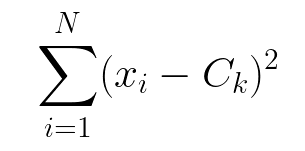
We also consider the Silhouette Coefficient. It is also another metric to compare between different clustering algorithms
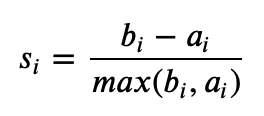
Where, <br>
ai = Intra Cluster distance for the point<br>
bi = Inter Cluster distance for the given point

We will consider the following algorithms for the data:
1. KMeans 
2. Gaussian Mixtures
3. MeanShift
4. Agglomerative Clustering

Other algorithms like Affinity Propagation, SpectralClustering also can be applied to clustering.

### K Means Analysis

The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares (WCSS) which was mentioned earlier. <br>
This algorithm requires the number of clusters to be specified.

#### Optimal K value selection using WCSS score

In [27]:
#Dataset for evaluation
X = df.copy(deep=True)

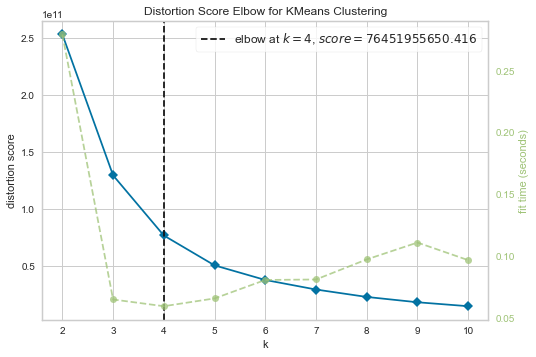

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [28]:
# Using the external library to plot the best value of K. The k range is checked from 2 to 7
# Note that this might not completely be accurate and we might take values based on visual analysis
elbow = KElbowVisualizer(KMeans(), k=10)
elbow.fit(X)
elbow.show()

#### Training the model

In [29]:
### Based on the above graph, we'll choose cluster value as 3, even though the graph is suggesting us 4,
### because the elbow point is higher and the time taken is lower
No_clusters = 3
#initializing the model
mod1 = KMeans(n_clusters=No_clusters,random_state=100)
#fitting the model with the data
mod1.fit(X)

#adding the cluster labels back to the dataframe
df['K Means No']= mod1.predict(X)
df

,Education,Marital_Status,Income,NumWebPurchases,NumWebVisitsMonth,Age,Offsprings,Years,Purchases,Money Spent,K Means No
0,2,1,58138.0,8,7,65,0,10,22,1617,2
1,2,1,46344.0,1,5,68,2,8,4,27,2
2,2,0,71613.0,8,4,57,0,9,20,776,1
3,2,0,26646.0,2,6,38,1,8,6,53,0
4,4,0,58293.0,5,5,41,1,8,14,422,2
...,...,...,...,...,...,...,...,...,...,...,...
2235,2,0,61223.0,9,5,55,1,9,16,1341,2
2236,4,0,64014.0,8,7,76,3,8,15,444,1
2237,2,1,56981.0,2,6,41,0,8,18,1241,2
2238,3,0,69245.0,6,3,66,1,8,21,843,1


In [30]:
# Let us see the silhouette scores to get a better understanding
# silouhette_score(df,mod1.labels_)
silhouette_score(X,mod1.labels_)

0.5512417524180728

Not bad! The silhouette score teaches us that this is a fairly good model!

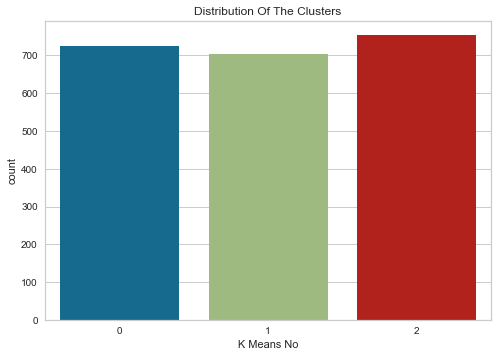

In [31]:
# Visualizing the distrubtion for each of the cluster divisions 
pl = sns.countplot(x=df["K Means No"])
pl.set_title("Distribution Of The Clusters")
plt.show()

Here on, by default, we'll choose the number of clusters to be 3 as this seems to give the best results

### Gaussian Mixture

As we saw in the earlier analysis, we will take the k parameter to be 3 test the model

In [32]:
#Initializing the model
mod2 = GaussianMixture(n_components=No_clusters, random_state=45)

# Fitting the data
mod2.fit(X)
#Adding the labels back to the dataframe, GM is Gaussian Mixture
df['GM No']=mod2.predict(X)
df

,Education,Marital_Status,Income,NumWebPurchases,NumWebVisitsMonth,Age,Offsprings,Years,Purchases,Money Spent,K Means No,GM No
0,2,1,58138.0,8,7,65,0,10,22,1617,2,0
1,2,1,46344.0,1,5,68,2,8,4,27,2,2
2,2,0,71613.0,8,4,57,0,9,20,776,1,1
3,2,0,26646.0,2,6,38,1,8,6,53,0,2
4,4,0,58293.0,5,5,41,1,8,14,422,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2235,2,0,61223.0,9,5,55,1,9,16,1341,2,0
2236,4,0,64014.0,8,7,76,3,8,15,444,1,1
2237,2,1,56981.0,2,6,41,0,8,18,1241,2,0
2238,3,0,69245.0,6,3,66,1,8,21,843,1,1


In [33]:
silhouette_score(df,mod2.predict(X))

0.28602137954716483

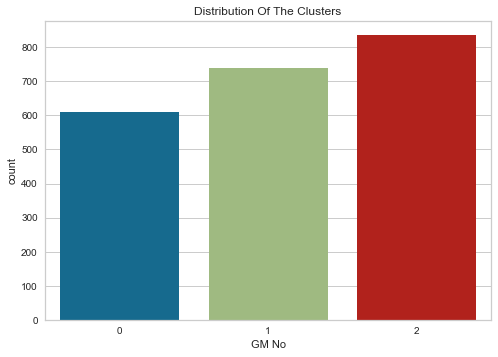

In [34]:
pl = sns.countplot(x=df["GM No"])
pl.set_title("Distribution Of The Clusters")
plt.show()

### MeanShift

We try using another clustering algorithm.<br>
MeanShift clustering aims to discover blobs in a smooth density of samples. It is a centroid based algorithm, which works by updating candidates for centroids to be the mean of the points within a given region.

In [35]:
#Initializing the model
mod3 = MeanShift(bandwidth=3)

# Fitting the data
mod3.fit(X)
#Adding the labels back to the dataframe. MS = MeanShift
df['MS No']=mod3.labels_
df

,Education,Marital_Status,Income,NumWebPurchases,NumWebVisitsMonth,Age,Offsprings,Years,Purchases,Money Spent,K Means No,GM No,MS No
0,2,1,58138.0,8,7,65,0,10,22,1617,2,0,1013
1,2,1,46344.0,1,5,68,2,8,4,27,2,2,1072
2,2,0,71613.0,8,4,57,0,9,20,776,1,1,1329
3,2,0,26646.0,2,6,38,1,8,6,53,0,2,1703
4,4,0,58293.0,5,5,41,1,8,14,422,2,1,441
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,2,0,61223.0,9,5,55,1,9,16,1341,2,0,1413
2236,4,0,64014.0,8,7,76,3,8,15,444,1,1,34
2237,2,1,56981.0,2,6,41,0,8,18,1241,2,0,1023
2238,3,0,69245.0,6,3,66,1,8,21,843,1,1,718


In [36]:
silhouette_score(df,mod3.labels_)

0.1813163958697023

The silhouette Score is very very less. Hence, we won't consider this for plotting

### Agglomerative Clustering

* This algorithm is a popular one and has much popularity as KMeans. Hence, we will dwell a little deeper into this algorithm. It is a subset of clustering algorithm technique called Heirarchical Clustering Algorithm. 
* Since Agglomerative Clustering is a part of Heirarchical Clustering, we could try to draw the heirarchial histogram and check out the optimum number of clusters

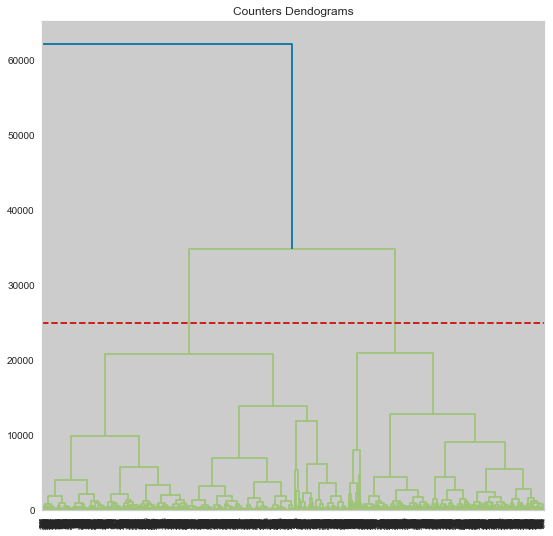

In [37]:
plt.figure(figsize=(9,9))
plt.title("Counters Dendograms")
dend_avg = shc.dendrogram(shc.linkage(y=X , method='average',metric='euclidean')
                          ,orientation='top') 
# Setting the "Proximity distance" metric for this to be 25000, we can cap how much accuracy we want.
plt.axhline( y = 25000, color='r',linestyle='--')
plt.show()

As we can see from the above plot, the optimal value of clusters seem to be 3. We'll confirm that using  ElbowVisualizer method also

#### Optimal K value selection using WCSS score

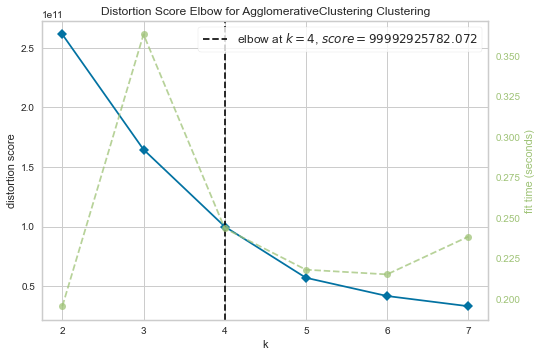

<AxesSubplot:title={'center':'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [38]:
#Trying to find the minimum k using Agglomerative Clustering
elbow = KElbowVisualizer(AgglomerativeClustering(), k=7)
elbow.fit(df)
elbow.show()

#### Training the model

In [39]:
# Here the graphs and the points match accurately, so we can consider
#the no of clusters as 3 itself
No_clusters_AC = No_clusters
mod4 = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage= 'average')
#fitting the instances
mod4.fit_predict(X)
# Adding the cluster no back to the original dataframe
df['AC No']=mod4.fit_predict(X)
df['AC No'].value_counts()

2    1333
0     850
1       1
Name: AC No, dtype: int64

In [40]:
silhouette_score(df,mod4.labels_)

0.5618869649890872

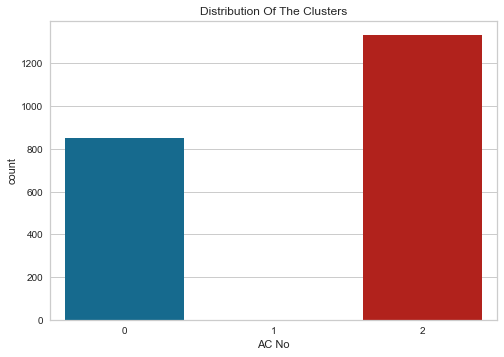

In [41]:
pl = sns.countplot(x=df["AC No"])
pl.set_title("Distribution Of The Clusters")
plt.show()

## Modelling Inference
* Out of the 4 algorithms we tested, we found that only KMeans and Agglomerative Clustering gave us comparative silhouette scores.
* The Agglmoerative model, shows skewed clustering as the number of points in many clusters are very low. To prevent this skew, we will consider the KMeans model for further inferences
* Hence, we will analysis the clustering of that model to categorize our customers

## Analysis of Data

This part of the notebook is vey crutial as it helps us model the results and how it should be analyzed. As mentioned earlier, we will use the KMeans model for its predictions for cluster analysis

In [42]:
# This part if for the analysis of the numerical variables in this dataset
# categorical values analysis will be the next

#Find the average of each group cluster
clusters_details = {}

#Running a for loop and calculating all mean values
for cluster in range(No_clusters):
    clusters_details[str(cluster)] = {}

    for column in num_cols:
        clusters_details[str(cluster)][column] = round(df[df["K Means No"]==cluster][column].mean(),2)

In [43]:
# This part is for the categorical variable analysis

# looping through each cluster
for cluster in range(No_clusters):
    # for each variable in cateogrical variables ( eduction and marital_status)
    for column in object_cols:
        # for calculating the ratio of ppl
        day = round(
        df[df["K Means No"]==cluster][column].value_counts() /
        df[df["K Means No"]==cluster][column].shape[0]
        ,2)
        test = day.to_dict()
        column_results = dict(zip(cat_var[column].values(),test.values()))

        #append this to the dataframe for each cluster
        for result in column_results:
            clusters_details[str(cluster)][result] = column_results[result]

In [44]:
Final= pd.DataFrame(clusters_details)
Final

,0,1,2
Income,28542.02,75373.38,51742.02
NumWebPurchases,2.18,5.49,4.64
NumWebVisitsMonth,6.78,3.30,5.73
Age,48.76,54.67,55.78
Offsprings,1.12,0.47,1.24
Years,8.97,8.95,9.01
Purchases,5.83,19.23,12.77
2n Cycle,0.51,0.53,0.48
Basic,0.16,0.23,0.25
Graduation,0.15,0.16,0.19


## Plotting of Data

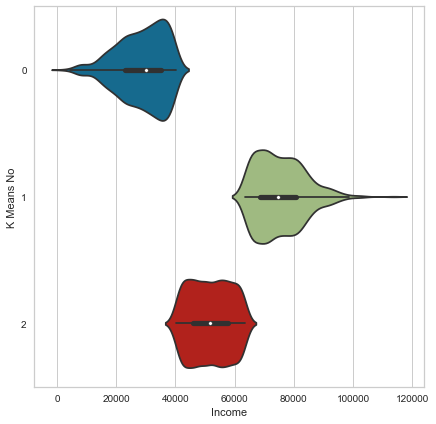

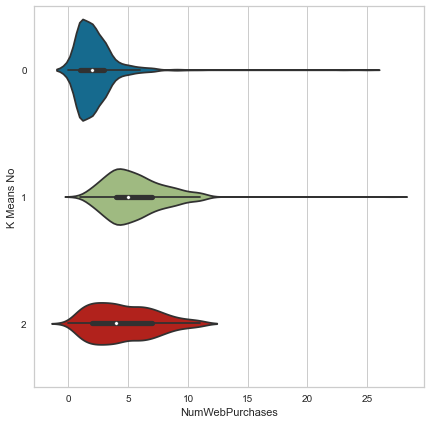

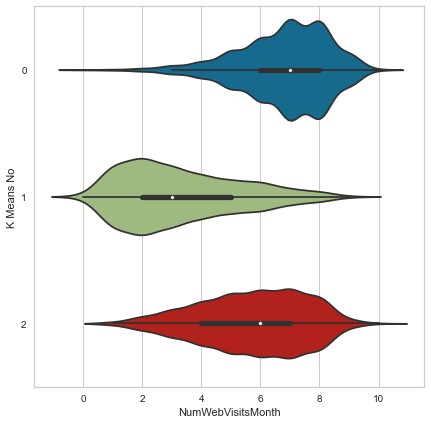

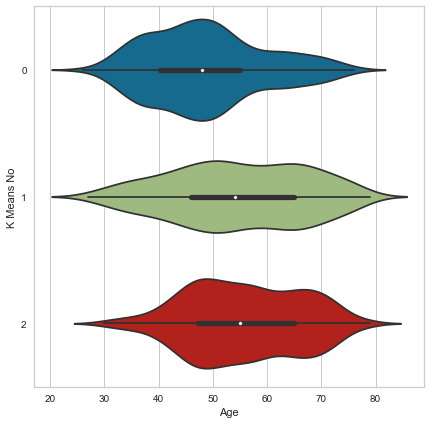

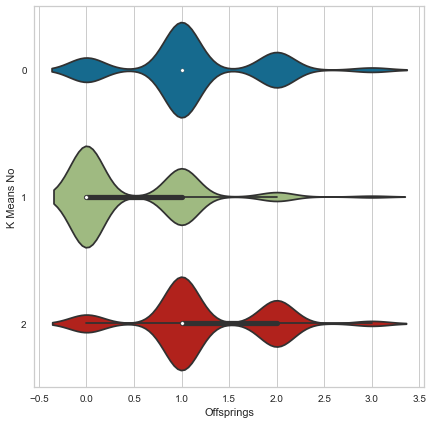

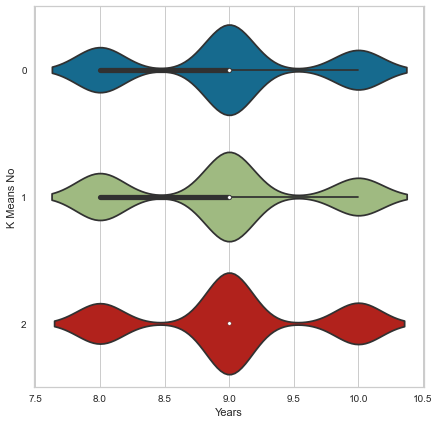

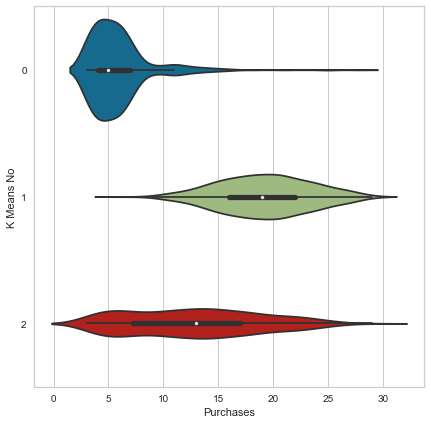

In [45]:
# Visualizing the differnces in plots

# For numerical variables
for column in num_cols:
    plt.figure(figsize=(7,7))
    sns.violinplot(y=df["K Means No"], x=df[column],  orient="h")
    plt.show();

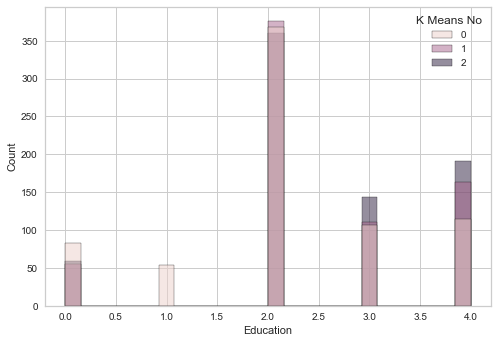

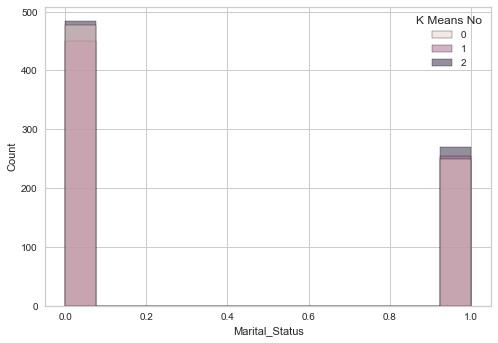

{'Marital_Status': {0: 'Relationship', 1: 'Single'}, 'Education': {0: '2n Cycle', 1: 'Basic', 2: 'Graduation', 3: 'Master', 4: 'PhD'}}


In [46]:
for column in object_cols:
    sns.histplot(x=df[column], hue =df["K Means No"])
    plt.show();
#for reference
print(cat_var)

## Conclusions

Based on the data analysis we have done, we can categorize the customers into the following categories. Various online marketing websites were consulted to do the categorization.

### Browsers or Lookers
1. Cluster 0 can be categorized as Browsing Customers or "Lookers".
2. Their average web purchases or 2, but no of web visits are almost 7.
3. This cluster has the youngest group of people with average age around 48.

### Rich Aristocrats
1. Cluster 1 can be classified as the Aristocratic Customers.
2. Earns the highest of the list with the mean around 75k per annum.
3. They rarely visit the website but when they do, they surely buy something as shown by their web purchases and visits.
4. Most of them on average have no kids.
5. Very interestingly, the number of PhD holders in this group is Nil. 

### Need-Based Customers
1. Cluster 2 can be classfied as Need Based Customers
2. These are the casual group who earn around 50k per annum and have 1 child on average.
3. They are the oldest group with average age of 56 years
4.  They are in par with Rich Customers with the purchases as their average purchases is 16. 


# Extending the model

* Here, we got a pretty good clustering algorithm, we will pipeline this algorithm through other classification algorithms to get a better prediction model.<br>

* We will create extra datasets by creating synthetic datasets using imblearn's SMOTE function. This is a random sampler using advanced metrics to create data similar to the training set.<br>

* Then we will train and classify with a K Nearest Neighbours model that gives us an accuracy of 99%.


### Preparation of Synthetic Datasetb

In [47]:
## Only keeping K means parameters
df.drop(['AC No','GM No','MS No'],axis = 1,inplace = True)
df

,Education,Marital_Status,Income,NumWebPurchases,NumWebVisitsMonth,Age,Offsprings,Years,Purchases,Money Spent,K Means No
0,2,1,58138.0,8,7,65,0,10,22,1617,2
1,2,1,46344.0,1,5,68,2,8,4,27,2
2,2,0,71613.0,8,4,57,0,9,20,776,1
3,2,0,26646.0,2,6,38,1,8,6,53,0
4,4,0,58293.0,5,5,41,1,8,14,422,2
...,...,...,...,...,...,...,...,...,...,...,...
2235,2,0,61223.0,9,5,55,1,9,16,1341,2
2236,4,0,64014.0,8,7,76,3,8,15,444,1
2237,2,1,56981.0,2,6,41,0,8,18,1241,2
2238,3,0,69245.0,6,3,66,1,8,21,843,1


In [48]:
## Dividing into data and labels
X,y = df.drop('K Means No',axis=1),  df['K Means No']

In [49]:
!pip install -U imbalanced-learn

## As mentioned earlier above using SMOTE method for creating more synthetic data
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 100)
X1,y1 = sm.fit_resample(X,y)

In [50]:
# Combining the original dataset and the synthetic one to create a bigger model for prediction
test = pd.concat([X,X1]).drop_duplicates(keep=False)
X = pd.concat([X,test])
y = y1[:-5]

### Supervised classification

We'll use simple supervised learning algorithm, K Nearest Neighbour Classifier to classify and predict what the outcome will be.

In [51]:
# Importing all libraries
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

### Dividing data in test and train sets

In [52]:
# We'll keep a larger test set beacuse we want to check the validity of the clustering algorithm
XTrain, XTest, ytrain, ytest = train_test_split(X, y, test_size=0.4, random_state=200)
XTrain.shape

(1354, 10)

### Fitting the model


In [53]:
neigh = KNeighborsClassifier(n_neighbors=3)

neigh.fit(XTrain, ytrain)
y_pred = neigh.predict(XTest)
y_pred

array([0, 1, 1, 1, 0, 2, 2, 2, 1, 2, 1, 1, 1, 2, 0, 2, 2, 1, 2, 2, 2, 2,
       0, 0, 0, 0, 0, 2, 1, 2, 1, 0, 2, 0, 1, 2, 0, 2, 1, 0, 0, 0, 0, 1,
       1, 2, 1, 1, 2, 0, 0, 1, 0, 2, 1, 2, 2, 1, 0, 2, 2, 0, 2, 1, 2, 1,
       0, 0, 2, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 2, 2, 1, 2, 0, 1, 0, 2,
       0, 0, 0, 1, 0, 2, 1, 1, 2, 0, 0, 0, 2, 0, 2, 2, 2, 1, 2, 1, 1, 2,
       0, 1, 0, 1, 2, 0, 2, 0, 2, 0, 1, 1, 1, 0, 2, 2, 2, 2, 0, 1, 2, 0,
       2, 0, 1, 1, 1, 2, 1, 2, 1, 2, 0, 0, 2, 1, 2, 1, 2, 1, 0, 0, 2, 0,
       1, 1, 1, 1, 0, 0, 2, 2, 1, 0, 1, 0, 0, 2, 2, 2, 1, 1, 2, 1, 1, 2,
       1, 2, 1, 2, 1, 2, 2, 2, 0, 0, 0, 2, 1, 1, 0, 0, 2, 2, 2, 2, 2, 0,
       0, 1, 2, 2, 1, 2, 1, 1, 0, 0, 1, 0, 2, 1, 1, 1, 1, 2, 0, 1, 0, 1,
       2, 1, 0, 1, 2, 2, 1, 0, 1, 1, 1, 1, 0, 2, 0, 1, 2, 0, 2, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 1, 0, 2, 1, 2, 2, 2, 2, 1, 2, 0, 0, 0, 0,
       0, 1, 0, 2, 0, 0, 1, 2, 0, 0, 0, 1, 0, 1, 0, 2, 1, 1, 2, 2, 0, 1,
       2, 2, 0, 1, 0, 1, 2, 1, 2, 2, 0, 2, 1, 0, 2,

### Testing the accuracy

In [54]:
metrics.accuracy_score(ytest,y_pred)

0.9988925802879292

We see accuracy of 99.8% which is a very good sign.There is a chance that the model is overfitted, but this is because of the low amount of data. But since the data is non linear in nature, there was a higher variance.This can be solved by acquiring and training on higher training data.

This model can be used for further prediction only after training much data

## References

#### Customer types research
https://www.tidio.com/blog/types-of-customers/ <br>
https://gettalkative.com/info/types-of-customers <br>

#### Theoretical Metrics
https://en.wikipedia.org/wiki/Silhouette_(clustering) <br>
https://scikit-learn.org/stable/modules/clustering.html <br>
https://tushar-joshi-89.medium.com/silhouette-score-a9f7d8d78f29 <br>
https://www.geeksforgeeks.org/ml-mean-shift-clustering/ <br>

#### Clustering Techniques
https://towardsdatascience.com/how-to-cluster-in-high-dimensions-4ef693bacc6 <br>
https://scikit-learn.org/stable/modules/clustering.html#spectral-clustering <br>

#### Others
https://chartio.com/learn/charts/box-plot-complete-guide/ <br>